Importation données / modules
====

In [576]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

In [577]:
file_name = 'btc_eur_3600.csv'
df_primary = pd.read_csv(r'C:\Users\flore\.spyder-py3\trading_bot\btc_eur_3600.csv', index_col='timestamp')

"""Normalisation"""

df_primary['bdb_high_n'] = df_primary['bdb_high'] / df_primary['opening_price']
df_primary['bdb_low_n'] = df_primary['bdb_low'] / df_primary['opening_price']
df_primary['high_price_n'] = df_primary['high_price'] / df_primary['opening_price']
df_primary['low_price_n'] = df_primary['low_price'] / df_primary['opening_price']
df_primary['mme12_n'] = df_primary['mme12'] / df_primary['opening_price']
df_primary['mme26_n'] = df_primary['mme26'] / df_primary['opening_price']
df_primary['macd_n'] = df_primary['macd'] / df_primary['opening_price']

"""Variables supplémentaires"""

df_primary['variation'] = (df_primary['closing_price'] - df_primary['opening_price']) / df_primary['opening_price']*100
df_primary['macd_derivative_n'] = df_primary['macd_n'] - df_primary['macd_n'].shift(1)
df_primary['macd_second_derivative_n'] = df_primary['macd_n'] + df_primary['macd_n'].shift(2)
df_primary['derivate_stochastic'] = df_primary['stochastic'] - df_primary['stochastic'].shift(1)
df_primary['volatility'] = df_primary['high_price_n'] - df_primary['low_price_n']
df_primary['derivate_volatility'] = df_primary['volatility'] - df_primary['volatility'].shift(1)
df_primary['derivate_volume'] = df_primary['volume'] - df_primary['volume'].shift(1)

"""abandon des variables redondantes"""

df_primary = df_primary.drop('closing_price', axis = 1)
df_primary = df_primary.drop('bdb_low', axis = 1)
df_primary = df_primary.drop('bdb_high', axis = 1)
df_primary = df_primary.drop('mme12', axis = 1)
df_primary = df_primary.drop('mme26', axis = 1)
df_primary = df_primary.drop('opening_price', axis = 1)
df_primary = df_primary.drop('low_price', axis = 1)
df_primary = df_primary.drop('high_price', axis = 1)
df_primary = df_primary.drop('length', axis = 1)
df_primary = df_primary.drop('date', axis = 1)
df_primary = df_primary.drop('macd', axis = 1) 

"""On décale d'un cran notre variation afin de pouvoir faire une étude cohérente"""

df_primary['variation'] = df_primary['variation'].shift(-1)

"""On lâche nos NaN"""

df_primary.dropna(inplace=True)
df = df_primary.copy()

print(df_primary.head())

                volume  stochastic  bdb_high_n  bdb_low_n  high_price_n  \
timestamp                                                                 
1504321200   31.744749    0.000000    0.998576   0.980936      1.002080   
1504324800   14.755165    0.642795    1.016936   0.999783      1.006496   
1504328400  185.642850    0.261647    1.016472   0.989490      1.000002   
1504332000  141.111493    0.999927    1.063922   1.035350      1.035192   
1504335600  100.007762    0.160596    1.027695   0.998875      1.013428   

            low_price_n   mme12_n   mme26_n    macd_n  variation  \
timestamp                                                          
1504321200     0.981055  0.861726  0.855708  0.006018   0.350023   
1504324800     0.998110  0.876122  0.871322  0.004800  -4.397400   
1504328400     0.940442  0.865095  0.864926  0.000169   3.518990   
1504332000     1.000000  0.903820  0.904702 -0.000882  -0.592246   
1504335600     0.990375  0.870613  0.872997 -0.002384  -0.144347  

In [715]:
def strategy_based_results(decisions_list, market_prices_deltas, fee_rate=0.3):
    """
    Returns the list of successive gains.
    Prints other info like number of hold, buy, sell, free_cash, fee costs.
    """

    cash = True
    decisions_results = [100]
    fees_cost = [100]
    free_cash = 0
    achat = 0
    vente = 0
    hold = 0

    for i in range(len(decisions_list)):

        if decisions_list[i] == 1 and cash:
            # Buy
            cash = False
            decisions_results.append(
                decisions_results[-1]*(100 + market_prices_deltas[i] - fee_rate) / 100)
            fees_cost.append(
                fees_cost[-1] + decisions_results[-1] * fee_rate / 100)
            achat += 1

        elif decisions_list[i] == -1 and cash:
            # Wait
            decisions_results.append(decisions_results[-1])
            free_cash += 1

        elif decisions_list[i] == 0 and cash:
            # Wait
            decisions_results.append(decisions_results[-1])
            free_cash += 1

        elif decisions_list[i] == 0 and not cash:
            # Hold
            decisions_results.append(
                decisions_results[-1] * (100 + market_prices_deltas[i]) / 100)
            hold += 1

        elif decisions_list[i] == -1 and not cash:
            # Sell
            cash = True
            decisions_results.append(
                decisions_results[-1] * (100 - fee_rate) / 100)
            fees_cost.append(
                fees_cost[-1] + decisions_results[-1] * fee_rate / 100)
            vente += 1

        elif decisions_list[i] == 1 and not cash:
            # Hold
            decisions_results.append(
                decisions_results[-1] * (100 + market_prices_deltas[i]) / 100)
            hold += 1

        else:
            raise Exception
    transactions = achat + vente
    print("Argent dépensé en commissions = ", str(round(fees_cost[-1] - 100, 2)), "%.")
    print("Nombre de transactions = ", str(achat + vente))
    print("Gain total = ", str(round(decisions_results[-1] - 100,2)), "%.")
    
    print("Argent dépensé en commissions = ", str(round(fees_cost[-1] - 100, 2)), "%.")
    print("Nombre de chandeliers sans cash engagé = ", str(free_cash))
    print("Nombre de chandeliers sur lesquels on a juste hold = ", str(hold))
    return decisions_results, transactions

In [679]:
def buy_hold_results(market_prices_deltas):
    """
    Return the lists of real market prices evolution
    """
    market_var = [100]
    for delta in market_prices_deltas:
        market_var.append(market_var[-1] * (100 + delta) / 100)
    #print("Variation réelle = ", str(round(market_var[-1] - 100,2)), "%.")
    return market_var

In [711]:
 def macd(data_row, seuil_a = -0.05, seuil_b = 0.0019, seuil_c = 0.014, seuil_d = -0.0225):
    """
    gain = 492%
    seuil_a = -0.05
    seuil_b = 0.002
    seuil_c = 0.014
    seuil_d = -0.0159
    
    transactions = 52
    Returns 0 for hold, 1 for buy, -1 for sell.
    """
    
    macd = data_row['macd_n']
    macd_derivative = data_row['macd_derivative_n']
    macd_second_derivative = data_row['macd_second_derivative_n']
    if macd >= seuil_a:
        if macd_derivative > seuil_b and macd_second_derivative > seuil_c:
            return 1
        else:
            if macd_second_derivative <= seuil_d:
                return -1
            else:
                return 0
    else:
        return -1

In [628]:

def optimisation_seuil_a(pas, debut, fin, seuil_a = 0, seuil_b = 0, seuil_c = 0, seuil_d = 0):
    init = debut
    liste_gain = []
    while debut < fin:       
        df_primary['macd_decision'] =  df_primary.apply(macd, args = (debut, seuil_b, seuil_c, seuil_d), axis=1)
        decisions_list = df_primary['macd_decision'].values.tolist()
        market_prices = df_primary['variation'].values.tolist()
        decisions_results, transactions = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3)
        market_var = buy_hold_results(market_prices)
        liste_gain.append(decisions_results[-1])
        debut += pas
        liste_transactions.append(transactions)
        
    index = liste_gain.index(max(liste_gain))
    seuil_a = index = index * pas + init
    print("Index du max = ", str(round(seuil_a ,4)))
    
    L = [i for i in range(len(liste_gain))]
    plt.plot(L, liste_gain)
    plt.show()
    return(seuil_a)








In [629]:
def optimisation_seuil_b(pas, debut, fin, seuil_a = 0, seuil_b = 0, seuil_c = 0, seuil_d = 0):
    init = debut
    liste_gain = []
    
    while debut < fin:       
        df_primary['macd_decision'] =  df_primary.apply(macd, args = (seuil_a, debut, seuil_c, seuil_d), axis=1)
        decisions_list = df_primary['macd_decision'].values.tolist()
        market_prices = df_primary['variation'].values.tolist()
        decisions_results, transactions = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3)
        market_var = buy_hold_results(market_prices)
        liste_gain.append(decisions_results[-1])
        debut += pas
        liste_transactions.append(transactions)
        
        
    index = liste_gain.index(max(liste_gain))
    seuil_b = index = index * pas + init
    print("Index du max = ", str(round(seuil_b ,4)))
    
    L = [i for i in range(len(liste_gain))]
    plt.plot(L, liste_gain)
    plt.show()
    return(seuil_b)


In [630]:
def optimisation_seuil_c(pas, debut, fin, seuil_a = 0, seuil_b = 0, seuil_c = 0, seuil_d = 0):
    init = debut
    liste_gain = []
    
    while debut < fin:       
        df_primary['macd_decision'] =  df_primary.apply(macd, args = (seuil_a, seuil_b, debut, seuil_d), axis=1)
        decisions_list = df_primary['macd_decision'].values.tolist()
        market_prices = df_primary['variation'].values.tolist()
        decisions_results, transactions = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3)
        market_var = buy_hold_results(market_prices)
        liste_gain.append(decisions_results[-1])
        debut += pas
        liste_transactions.append(transactions)
        
        
    index = liste_gain.index(max(liste_gain))
    seuil_c = index = index * pas + init
    print("Index du max = ", str(round(seuil_c ,4)))
    
    L = [i for i in range(len(liste_gain))]
    plt.plot(L, liste_gain)
    plt.show()
    return(seuil_c)




In [681]:
def optimisation_seuil_d(pas, debut, fin, seuil_a = 0, seuil_b = 0, seuil_c = 0, seuil_d = 0):
    init = debut
    liste_gain = []
    
    while debut < fin:       
        df_primary['macd_decision'] =  df_primary.apply(macd, args = (seuil_a, seuil_b, seuil_c, debut), axis=1)
        decisions_list = df_primary['macd_decision'].values.tolist()
        market_prices = df_primary['variation'].values.tolist()
        decisions_results = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3)
        market_var = buy_hold_results(market_prices)
        liste_gain.append(decisions_results[-1])
        debut += pas
        
        
        
    index = liste_gain.index(max(liste_gain))
    seuil_d = index = index * pas + init
    print("Index du max = ", str(round(seuil_d ,4)))
    
    L = [i for i in range(len(liste_gain))]
    plt.plot(L, liste_gain)
    plt.show()
    return(seuil_d)

Index du max =  -0.0225


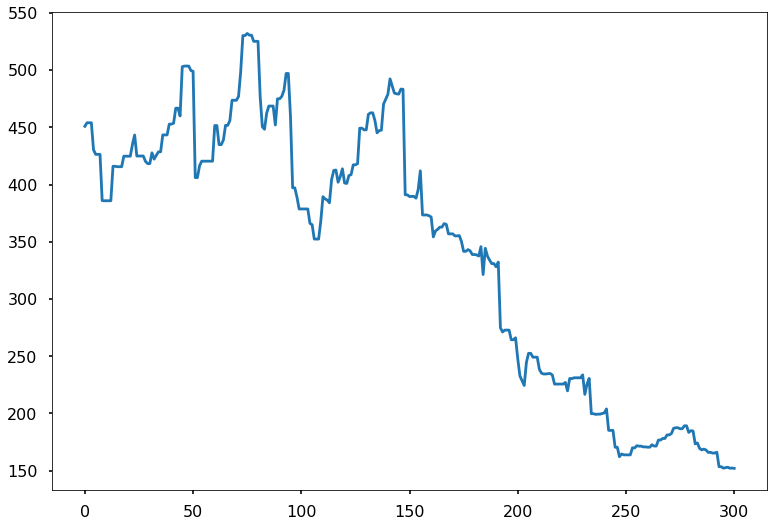

In [684]:
"""seuil_a = optimisation_seuil_macd(pas = 0.0001, debut = -0.03, fin= 0)
seuil_b = optimisation_seuil_b(pas = 0.0001, debut = -0.01, fin = 0.01, seuil_d = seuil_d)
seuil_c = optimisation_seuil_c(pas = 0.0001, debut = -0.03, fin = 0.03, seuil_a = seuil_a, seuil_b = seuil_b)"""
seuil_d = optimisation_seuil_d(pas = 0.0001, debut = -0.03, fin = 0, seuil_a = -0.05, seuil_b = 0.002, seuil_c = 0.014)

In [703]:
def gainfunction(seuil_a, seuil_b, seuil_c, seuil_d):
    df_primary['macd_decision'] =  df_primary.apply(macd, args = (seuil_a, seuil_b, seuil_c, seuil_d), axis=1)
    decisions_list = df_primary['macd_decision'].values.tolist()
    market_prices = df_primary['variation'].values.tolist()
    gain = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3)
    return(gain)
print(gainfunction(-0.05,0.0019,0.014,-0.0225))

-589.5185694812845


In [694]:
# Gradient Descent

liste_gain = []

alpha = 0.0000000001 # learning rate
nb_max_iter = 100 # Nb max d'iteration

seuil_a_0 = -0.05 # start point00
seuil_b_0 =  0.002
seuil_c_0 = 0.014 
seuil_d_0 = -0.0225


pas = 0.001

nb_iter = 0 

while nb_iter < nb_max_iter:

    
    seuil_a_1 = seuil_a_0 - alpha * ((gainfunction(seuil_a_0 + pas, seuil_b_0, seuil_c_0, seuil_d_0) - 
                                      gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)) / pas)
    
    seuil_b_1 = seuil_b_0 - alpha * ((gainfunction(seuil_a_0, seuil_b_0 + pas, seuil_c_0, seuil_d_0) - 
                                      gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)) / pas)
    
    seuil_c_1 = seuil_c_0 - alpha * ((gainfunction(seuil_a_0, seuil_b_0, seuil_c_0 + pas, seuil_d_0) - 
                                      gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)) / pas)
    
    seuil_d_1 = seuil_d_0 - alpha * ((gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0 + pas) - 
                                      gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)) / pas)
    
    seuil_a_0 = seuil_a_1
    seuil_b_0 = seuil_b_1
    seuil_c_0 = seuil_c_1
    seuil_d_0 = seuil_d_1

    print(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)


    gain = gainfunction(seuil_a_0, seuil_b_0, seuil_c_0, seuil_d_0)
    print(gain)
    liste_gain.append(gain)
    nb_iter = nb_iter + 1
    print(nb_iter)

L = [i for i in range(len(liste_gain))]

plt.plot(L, liste_gain)
plt.show()

-0.05 0.001969213333912114 0.013997331950286435 -0.02250634254560426
-497.9301749155594
1
-0.05 0.001941832539721145 0.01399483471307748 -0.0225122790320205
-497.9301749155594
2
-0.05 0.001914451745530176 0.013992337475868526 -0.022518215518436743
-504.12123188073355
3
-0.05 0.0018864518456426895 0.013991494845230252 -0.022524225816659194
-589.5185694812845
4
-0.05 0.0018556341223892995 0.013990509474297504 -0.022531254249873636
-535.6030271314352
5
-0.05 0.0018305493439904619 0.01398961422233811 -0.02253691061182797
-535.6030271314352
6
-0.05 0.0018054645655916244 0.013988718970378717 -0.022542566973782305
-535.6030271314352
7
-0.05 0.001780379787192787 0.013987823718419324 -0.02254822333573664
-535.6030271314352
8
-0.05 0.0017552950087939495 0.01398692846645993 -0.022553879697690973
-480.8290072474159
9
-0.05 0.001735687632383514 0.013991510616488938 -0.02255884324928978
-479.1750457412174
10
-0.05 0.0017170609106153469 0.013996077004782176 -0.02256364140473796
-428.0898163274334
11


KeyboardInterrupt: 

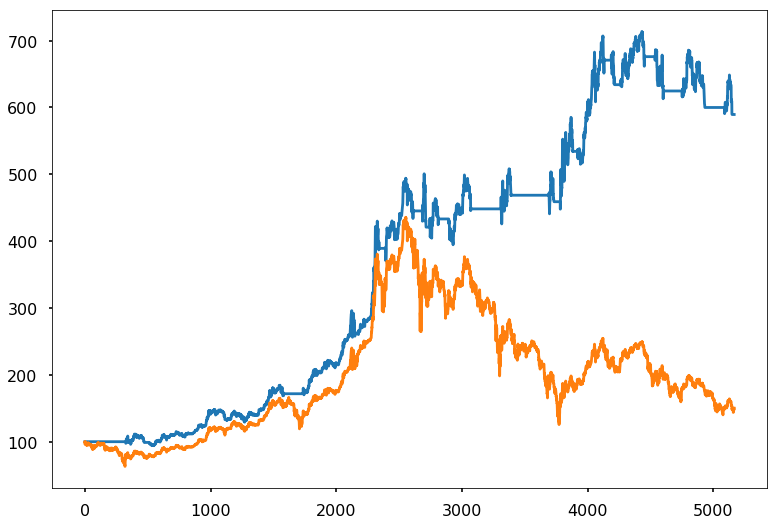

In [707]:
df_primary['macd_decision'] =  df_primary.apply(macd, args = (-0.05, 0.0019, 0.014, -0.0225), axis=1)
decisions_list = df_primary['macd_decision'].values.tolist()
market_prices = df_primary['variation'].values.tolist()
decisions_results, transactions = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3)
market_var = buy_hold_results(market_prices)

L = [i for i in range(len(decisions_results))]
plt.plot(L, decisions_results)
plt.plot(L, market_var)
plt.show()

In [708]:
 def bdb_high(data_row, seuil_bdb_high):
        
    bdb_high = data_row['bdb_high_n']
    if bdb_high > seuil_bdb_high:
        return -1
    else:
        return 0

In [709]:
 def bdb_low(data_row, seuil_bdb_low):
        
    bdb_low = data_row['bdb_low_n']
    if bdb_low < seuil_bdb_low:
        return 1
    else:
        return 0

In [710]:
def decision_vector(data_row):
    macd_decision = data_row['macd_decision']
    bdb_low_decision = data_row['bdb_low_decision']
    bdb_high_decision = data_row['bdb_high_decision']
    if bdb_low_decision == 0 and bdb_high_decision == 0:
        return macd_decision
    elif bdb_low_decision == 1:
        return 1
    elif bdb_high_decision == -1:
        return -1
    else:
        return 5
    

0.95
0.949
0.948
0.947
0.946
0.945
0.944
0.943
0.942
0.941
0.94
0.939
0.938
0.9369999999999999
0.9359999999999999
0.9349999999999999
0.9339999999999999
0.9329999999999999
0.9319999999999999
0.9309999999999999
0.9299999999999999
0.9289999999999999
0.9279999999999999
0.9269999999999999
0.9259999999999999
0.9249999999999999
0.9239999999999999
0.9229999999999999
0.9219999999999999
0.9209999999999999
0.9199999999999999
0.9189999999999999
0.9179999999999999
0.9169999999999999
0.9159999999999999
0.9149999999999999
0.9139999999999999
0.9129999999999999
0.9119999999999999
0.9109999999999999
0.9099999999999999
0.9089999999999999
0.9079999999999999
0.9069999999999999
0.9059999999999999
0.9049999999999999
0.9039999999999999
0.9029999999999999
0.9019999999999999
0.9009999999999999
0.8999999999999999
0.8989999999999999
0.8979999999999999
0.8969999999999999
0.8959999999999999
0.8949999999999999
0.8939999999999999
0.8929999999999999
0.8919999999999999
0.8909999999999999
0.8899999999999999
0.889
0.8879

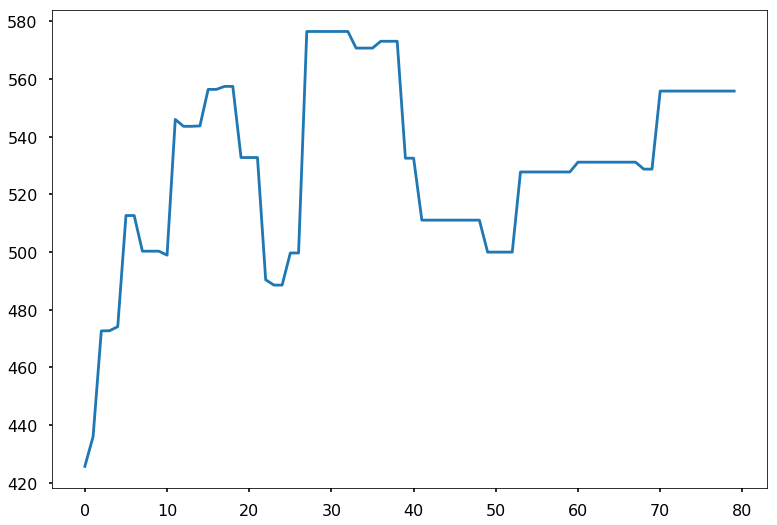

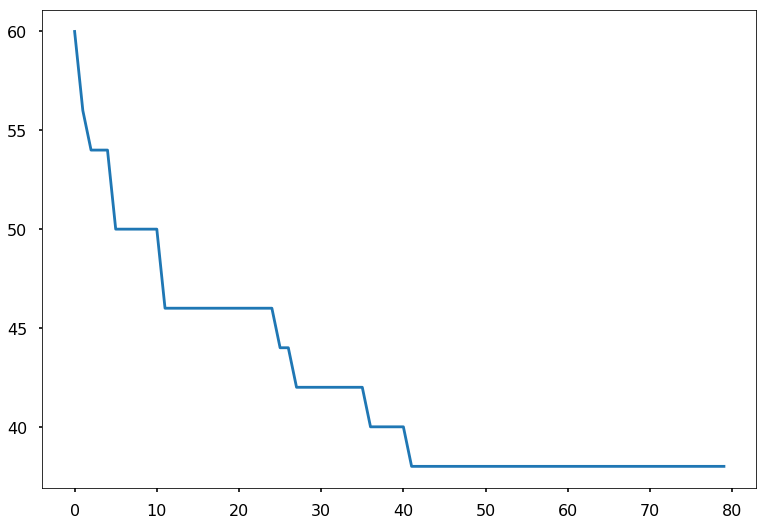

In [713]:
liste_gain = []
liste_transactions = []

pas = 0.001
for i in range (1):
    i = 1 + i * pas
    i = 1.5
    for j in range (80):
        j = 0.95 - j * pas
        
        df['bdb_high_decision'] =  df.apply(bdb_high, args = (i,), axis=1)
        df['bdb_low_decision'] =  df.apply(bdb_low, args = (j,), axis=1)
        df['macd_decision'] = df.apply(macd, axis = 1)
        df['decision_vector'] = df.apply(decision_vector, axis = 1)
        decisions_list = df['decision_vector'].values.tolist()
        market_prices = df['variation'].values.tolist()
        
        decisions_results, transactions = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3)
        market_var = buy_hold_results(market_prices)
        liste_gain.append(decisions_results[-1])
        liste_transactions.append(transactions)
        print(j)
       
    
index = liste_gain.index(max(liste_gain))
index = - index * pas + 0.95
print("Index du max = ", str(round(index ,4)))
L = [i for i in range(len(liste_gain))]
plt.plot(L, liste_gain)
plt.show()
plt.plot(L, liste_transactions)
plt.show()

Argent dépensé en commissions =  50.72 %.
Nombre de transactions =  38
Gain total =  489.52 %.
Argent dépensé en commissions =  50.72 %.
Nombre de chandeliers sans cash engagé =  1908
Nombre de chandeliers sur lesquels on a juste hold =  3219


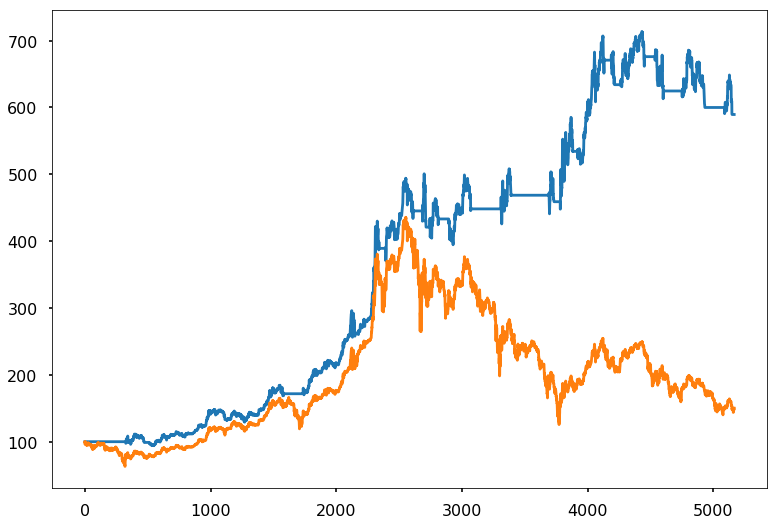

In [718]:
df['bdb_high_decision'] =  df.apply(bdb_high, args = (1.5,), axis=1)
df['bdb_low_decision'] =  df.apply(bdb_low, args = (0.8,), axis=1)
df['macd_decision'] = df.apply(macd, axis = 1)
df['decision_vector'] = df.apply(decision_vector, axis = 1)
decisions_list = df['decision_vector'].values.tolist()
market_prices = df['variation'].values.tolist()

decisions_results, transactions = strategy_based_results(decisions_list, market_prices, fee_rate = 0.3)
market_var = buy_hold_results(market_prices)
liste_gain.append(decisions_results[-1])
liste_transactions.append(transactions)
I = [i for i in range(len(decisions_results))]
plt.plot(I, decisions_results)
plt.plot(I, market_var)
plt.show()

In [587]:

Nombre de transactions =  24
def bdb_low(df, seuil = 1.0348):
    
    bdb_low = df['bdb_low_n'].values.tolist()
    bdb_low_perso = []
    
    for i in range(len(bdb_low)):
        
        if bdb_low[i] >= seuil:
            bdb_low_perso.append(1)
        else:
            bdb_low_perso.append(0)
            
    return(bdb_low_perso)

SyntaxError: invalid syntax (<ipython-input-587-6c67c022c2f0>, line 2)